In [33]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 12, 7
from sklearn.svm import SVC  
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import datetime as dt
from datetime import datetime

In [2]:
# Get the curent date/time
today = pd.to_datetime('today')

In [3]:
# Downloads the lates data availlable and saves it.
# Run this step dayly to update the data.

df_Covid_data = pd.read_csv('https://covidtracking.com/data/download/national-history.csv')
df_Covid_data.to_csv('National_Covid_Data_'+today.strftime("%Y-%m-%d")+'.csv')

In [4]:
# Loads the last saved data. Make sure the data is up to date by running the cell above. 
df_Covid_data = pd.read_csv('National_Covid_Data_'+today.strftime("%Y-%m-%d")+'.csv')
df_Covid_data.head()

,Unnamed: 0,date,death,deathIncrease,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCumulative,onVentilatorCurrently,positive,positiveIncrease,recovered,states,totalTestResults,totalTestResultsIncrease
0,0,2020-12-08,277367.0,2622,32406.0,20483.0,4193,104600.0,593679.0,164563564,1184838,3359.0,7245.0,14930563,213498,5786915.0,56,207572528,1638354
1,1,2020-12-07,274745.0,1347,32120.0,20098.0,3614,102148.0,589486.0,163378726,1386381,3328.0,7073.0,14717065,180193,5714557.0,56,205934174,1835388
2,2,2020-12-06,273398.0,1146,31946.0,20145.0,2311,101501.0,585872.0,161992345,1175503,3322.0,7095.0,14536872,177801,5624609.0,56,204098786,1648306
3,3,2020-12-05,272252.0,2461,31831.0,19947.0,3457,101192.0,583561.0,160816842,1530133,3321.0,7006.0,14359071,212880,5576152.0,56,202450480,2190899
4,4,2020-12-04,269791.0,2563,31608.0,19858.0,4652,101276.0,580104.0,159286709,1260657,3305.0,6999.0,14146191,224831,5470389.0,56,200259581,1854869


In [5]:
# Check for shape, null values and data types of the data
print("Size/Shape of the dataset",df_Covid_data.shape)
print("Checking for null values:\n",df_Covid_data.isnull().sum())
print("Checking Data-type:",df_Covid_data.dtypes)

Size/Shape of the dataset (322, 19)
Checking for null values:
 Unnamed: 0                   0
date                         0
death                       19
deathIncrease                0
inIcuCumulative             63
inIcuCurrently              64
hospitalizedIncrease         0
hospitalizedCurrently       55
hospitalizedCumulative      42
negative                     0
negativeIncrease             0
onVentilatorCumulative      70
onVentilatorCurrently       63
positive                     0
positiveIncrease             0
recovered                   63
states                       0
totalTestResults             0
totalTestResultsIncrease     0
dtype: int64
Checking Data-type: Unnamed: 0                    int64
date                         object
death                       float64
deathIncrease                 int64
inIcuCumulative             float64
inIcuCurrently              float64
hospitalizedIncrease          int64
hospitalizedCurrently       float64
hospitalizedCumulative     

In [6]:
# Print the column names
df_Covid_data.columns

Index(['Unnamed: 0', 'date', 'death', 'deathIncrease', 'inIcuCumulative',
       'inIcuCurrently', 'hospitalizedIncrease', 'hospitalizedCurrently',
       'hospitalizedCumulative', 'negative', 'negativeIncrease',
       'onVentilatorCumulative', 'onVentilatorCurrently', 'positive',
       'positiveIncrease', 'recovered', 'states', 'totalTestResults',
       'totalTestResultsIncrease'],
      dtype='object')

In [7]:
#Drop columns that are not needed for the model
df_Covid_data.drop(['Unnamed: 0','death',\
       'deathIncrease','onVentilatorCumulative','states'],1,inplace = True)

In [8]:
df_Covid_data.columns

Index(['date', 'inIcuCumulative', 'inIcuCurrently', 'hospitalizedIncrease',
       'hospitalizedCurrently', 'hospitalizedCumulative', 'negative',
       'negativeIncrease', 'onVentilatorCurrently', 'positive',
       'positiveIncrease', 'recovered', 'totalTestResults',
       'totalTestResultsIncrease'],
      dtype='object')

In [9]:
df_Covid_data.head()

,date,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCurrently,positive,positiveIncrease,recovered,totalTestResults,totalTestResultsIncrease
0,2020-12-08,32406.0,20483.0,4193,104600.0,593679.0,164563564,1184838,7245.0,14930563,213498,5786915.0,207572528,1638354
1,2020-12-07,32120.0,20098.0,3614,102148.0,589486.0,163378726,1386381,7073.0,14717065,180193,5714557.0,205934174,1835388
2,2020-12-06,31946.0,20145.0,2311,101501.0,585872.0,161992345,1175503,7095.0,14536872,177801,5624609.0,204098786,1648306
3,2020-12-05,31831.0,19947.0,3457,101192.0,583561.0,160816842,1530133,7006.0,14359071,212880,5576152.0,202450480,2190899
4,2020-12-04,31608.0,19858.0,4652,101276.0,580104.0,159286709,1260657,6999.0,14146191,224831,5470389.0,200259581,1854869


In [11]:
start_date = "2020-03-20"
end_date = "2020-12-02"
mask = (df_Covid_data["date"] > start_date) & (df_Covid_data["date"] <= end_date)
covid_df = df_Covid_data.loc[mask]
covid_df.head()

,date,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCurrently,positive,positiveIncrease,recovered,totalTestResults,totalTestResultsIncrease
6,2020-12-02,31038.0,19680.0,5028,100322.0,570121.0,156787587,982032,6855.0,13711156,195796,5322128.0,196576482,1459202
7,2020-12-01,30749.0,19295.0,5222,98777.0,565093.0,155805555,1941714,6649.0,13515360,176753,5226581.0,195117280,2340996
8,2020-11-30,30469.0,18801.0,3394,96149.0,559871.0,153863841,1219808,6520.0,13338607,147587,5146643.0,192776284,1603253
9,2020-11-29,30274.0,18437.0,2429,93357.0,556477.0,152644033,883148,6245.0,13191020,135242,5065148.0,191173031,1289970
10,2020-11-28,30109.0,18249.0,3404,91762.0,554048.0,151760885,1276935,6148.0,13055778,154522,5024447.0,189883061,1709566


In [12]:
# Set the date as index
covid_df.set_index('date', inplace =True)
covid_df.head()

,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCurrently,positive,positiveIncrease,recovered,totalTestResults,totalTestResultsIncrease
date,,,,,,,,,,,,,
2020-12-02,31038.0,19680.0,5028,100322.0,570121.0,156787587,982032,6855.0,13711156,195796,5322128.0,196576482,1459202
2020-12-01,30749.0,19295.0,5222,98777.0,565093.0,155805555,1941714,6649.0,13515360,176753,5226581.0,195117280,2340996
2020-11-30,30469.0,18801.0,3394,96149.0,559871.0,153863841,1219808,6520.0,13338607,147587,5146643.0,192776284,1603253
2020-11-29,30274.0,18437.0,2429,93357.0,556477.0,152644033,883148,6245.0,13191020,135242,5065148.0,191173031,1289970
2020-11-28,30109.0,18249.0,3404,91762.0,554048.0,151760885,1276935,6148.0,13055778,154522,5024447.0,189883061,1709566


In [13]:
# clean missing values using fillna() method with ffill parameter which propagates last valid observation to fill gaps
covid_df = covid_df.iloc[1:]
covid_df = covid_df.fillna(method='ffill')
covid_df.head()


,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCurrently,positive,positiveIncrease,recovered,totalTestResults,totalTestResultsIncrease
date,,,,,,,,,,,,,
2020-12-01,30749.0,19295.0,5222,98777.0,565093.0,155805555,1941714,6649.0,13515360,176753,5226581.0,195117280,2340996
2020-11-30,30469.0,18801.0,3394,96149.0,559871.0,153863841,1219808,6520.0,13338607,147587,5146643.0,192776284,1603253
2020-11-29,30274.0,18437.0,2429,93357.0,556477.0,152644033,883148,6245.0,13191020,135242,5065148.0,191173031,1289970
2020-11-28,30109.0,18249.0,3404,91762.0,554048.0,151760885,1276935,6148.0,13055778,154522,5024447.0,189883061,1709566
2020-11-27,29858.0,18061.0,3499,89950.0,550644.0,150483950,1504431,6030.0,12901256,193725,4947446.0,188173495,2126288


In [14]:
#Create a single dataframe for Hospitalization
hosp_df = pd.DataFrame(covid_df.hospitalizedCurrently)
hosp_df.head()

,hospitalizedCurrently
date,
2020-12-01,98777.0
2020-11-30,96149.0
2020-11-29,93357.0
2020-11-28,91762.0
2020-11-27,89950.0


In [15]:
hosp_df = hosp_df.sort_index()
hosp_df.head()

,hospitalizedCurrently
date,
2020-03-21,1492.0
2020-03-22,2173.0
2020-03-23,2812.0
2020-03-24,3938.0
2020-03-25,5140.0


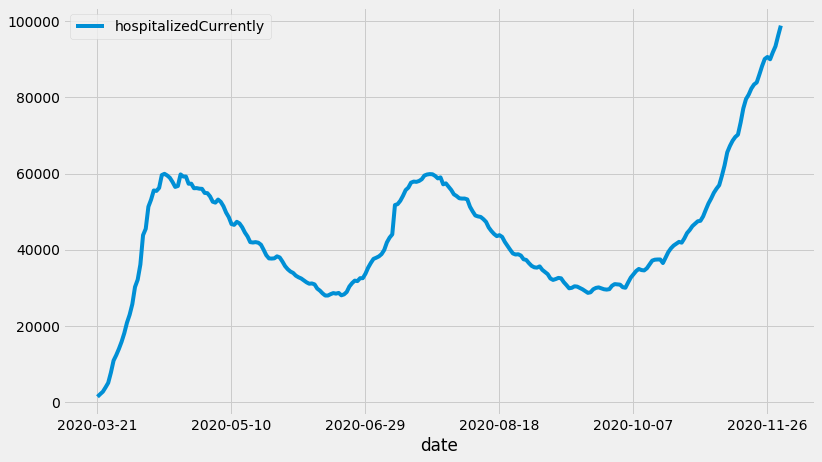

In [38]:
# Visualizing the time series.
# plt.xlabel("date")
# plt.ylabel("Current Hospitalization")
# plt.title("Hospitalization graph")
hosp_df.plot()
plt.show()


# The mean is not constant as we can clearly see an upward trend
hence the series is not stationary
Lets try to convert the data into a stationary one

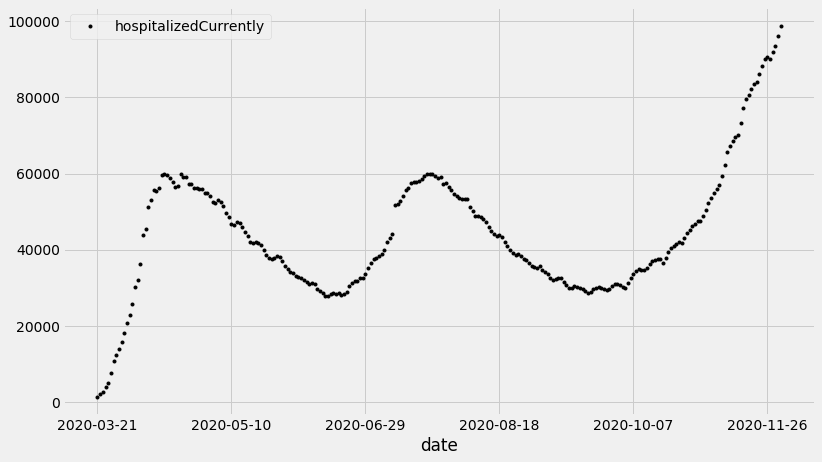

In [35]:
hosp_df.plot(style='k.')
plt.show()


In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(hosp_df['hospitalizedCurrently'], model='multiplicative')
result.plot()
plt.show()

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

Clearly, there is an upward trend and a recurring event where electricity consumption shoots maximum every year.
we need to check if a series is stationary or not via the ADL test

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary (we will understand more about difference stationary in the next section).

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

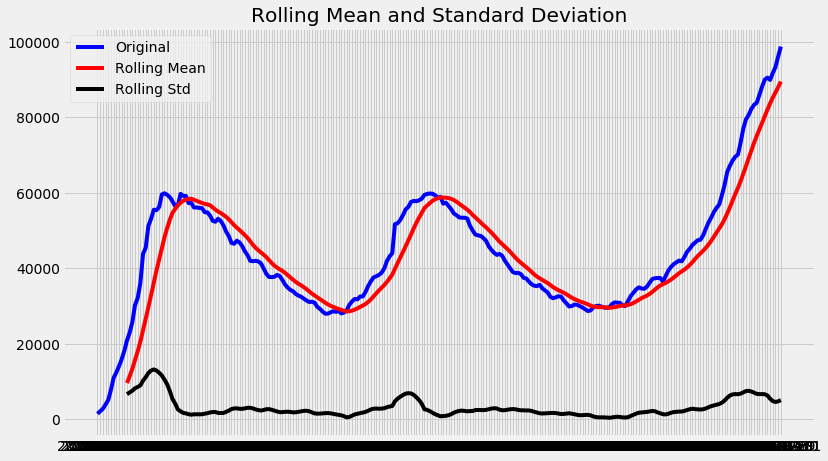

Results of dickey fuller test
Test Statistics                 -1.556292
p-value                          0.505504
No. of lags used                 9.000000
Number of observations used    246.000000
critical value (1%)             -3.457215
critical value (5%)             -2.873362
critical value (10%)            -2.573070
dtype: float64


In [44]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #perform dickey fuller test  
    print("Results of dickey fuller test")
    adft = adfuller(timeseries['hospitalizedCurrently'],autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(hosp_df)

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

To get a stationary series, we need to eliminate the trend and seasonality from the series.


we start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

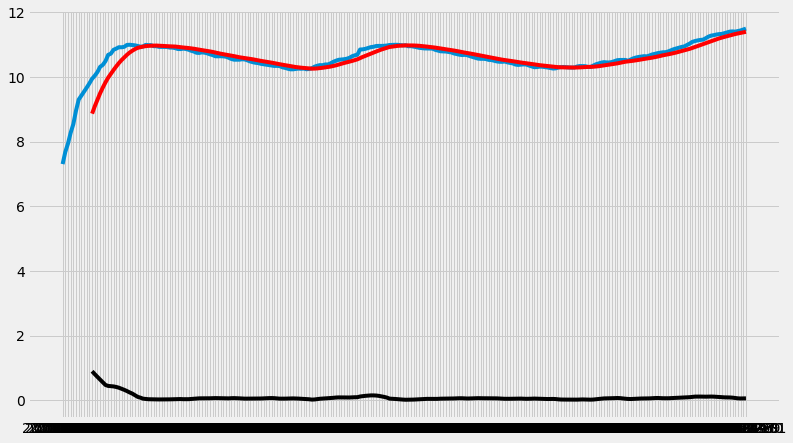

In [45]:
hosp_log = np.log(hosp_df)
moving_avg = hosp_log.rolling(12).mean()
std_dev = hosp_log.rolling(12).std()
plt.plot(hosp_log)
plt.plot(moving_avg, color="red")
plt.plot(std_dev, color ="black")
plt.show()

After finding the mean, we take the difference of the series and the mean at every point in the series.

This way, we eliminate trends out of a series and obtain a more stationary series.

In [22]:
hosp_log_moving_avg_diff = hosp_log-moving_avg
hosp_log_moving_avg_diff.dropna(inplace=True)
hosp_log_moving_avg_diff

,hospitalizedCurrently
date,
2020-04-01,1.078680
2020-04-02,0.946070
2020-04-03,0.854075
2020-04-04,0.816667
2020-04-05,0.702865
...,...
2020-11-27,0.073550
2020-11-28,0.074862
2020-11-29,0.076128


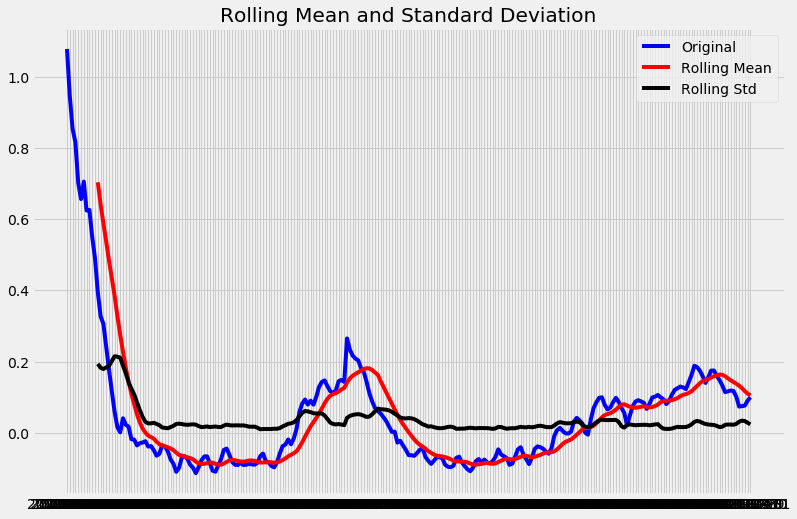

Results of dickey fuller test
Test Statistics                 -2.726751
p-value                          0.069522
No. of lags used                14.000000
Number of observations used    230.000000
critical value (1%)             -3.459106
critical value (5%)             -2.874190
critical value (10%)            -2.573512
dtype: float64


In [23]:
# Perform the Dickey-Fuller test (ADFT) once again
test_stationarity(hosp_log_moving_avg_diff)

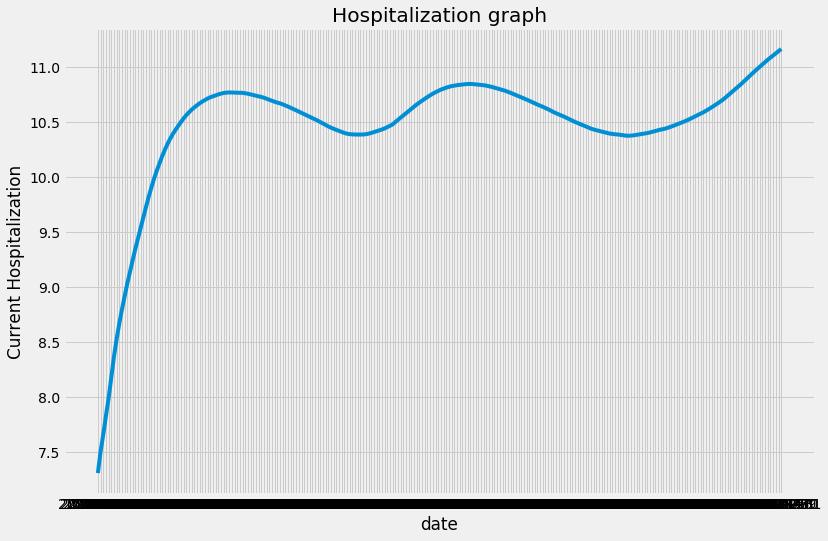

In [24]:
# We need to check the weighted average, to understand the trend of the data in time series.
weighted_average = hosp_log.ewm(halflife=12, min_periods=0,adjust=True).mean()

plt.xlabel("date")
plt.ylabel("Current Hospitalization")
plt.title("Hospitalization graph")
plt.plot(weighted_average)

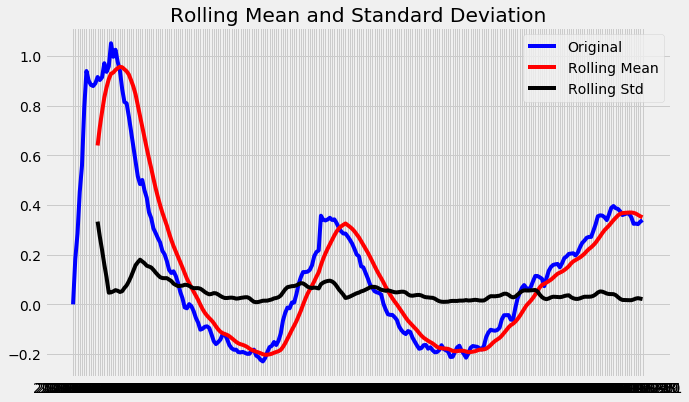

Results of dickey fuller test
Test Statistics               -5.915662e+00
p-value                        2.576502e-07
No. of lags used               1.400000e+01
Number of observations used    2.410000e+02
critical value (1%)           -3.457779e+00
critical value (5%)           -2.873609e+00
critical value (10%)          -2.573202e+00
dtype: float64


In [25]:
#perform the Dickey-Fuller test (ADFT) once again
logScale_weightedMean = hosp_log-weighted_average
from pylab import rcParams
rcParams['figure.figsize'] = 10,6
test_stationarity(logScale_weightedMean)

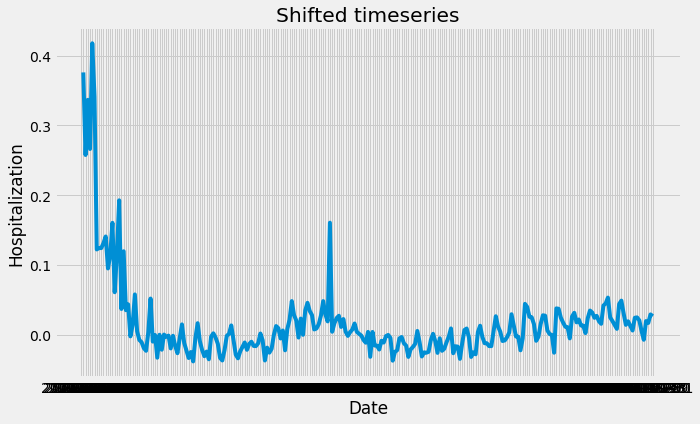

In [26]:
#Differencing is a method of transforming a time series dataset.
hosp_log_diff = hosp_log - hosp_log.shift()
plt.title("Shifted timeseries")
plt.xlabel("Date")
plt.ylabel("Hospitalization")
plt.plot(hosp_log_diff)


In [27]:
#Let us test the stationarity of our resultant series
hosp_log_diff.dropna(inplace=True)

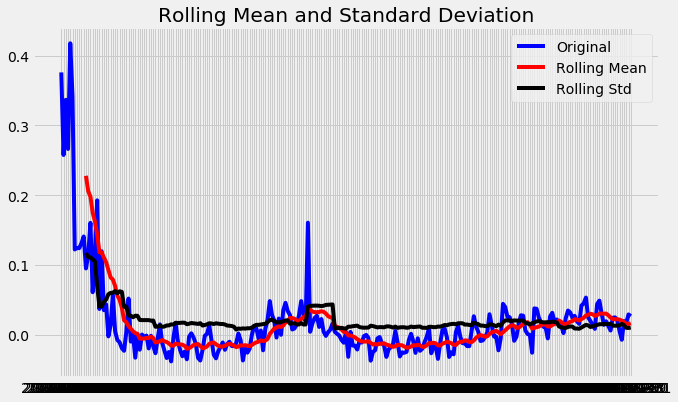

Results of dickey fuller test
Test Statistics                 -4.804775
p-value                          0.000053
No. of lags used                16.000000
Number of observations used    238.000000
critical value (1%)             -3.458128
critical value (5%)             -2.873762
critical value (10%)            -2.573283
dtype: float64


In [28]:
test_stationarity(hosp_log_diff)

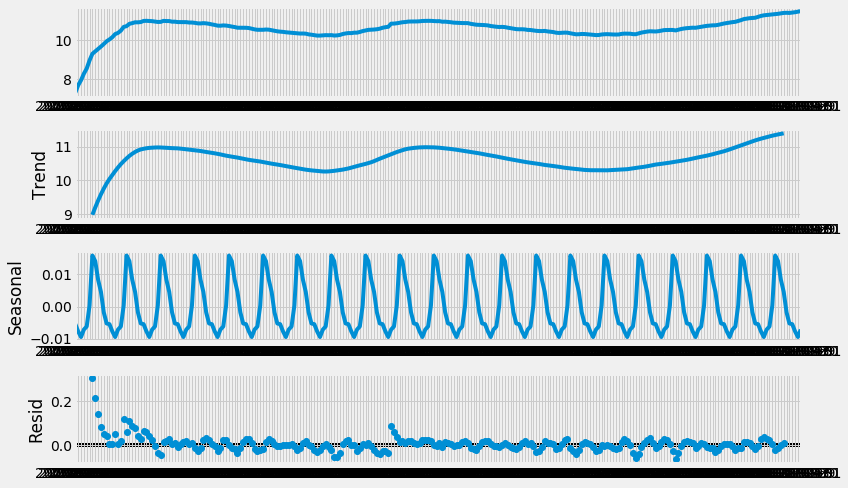

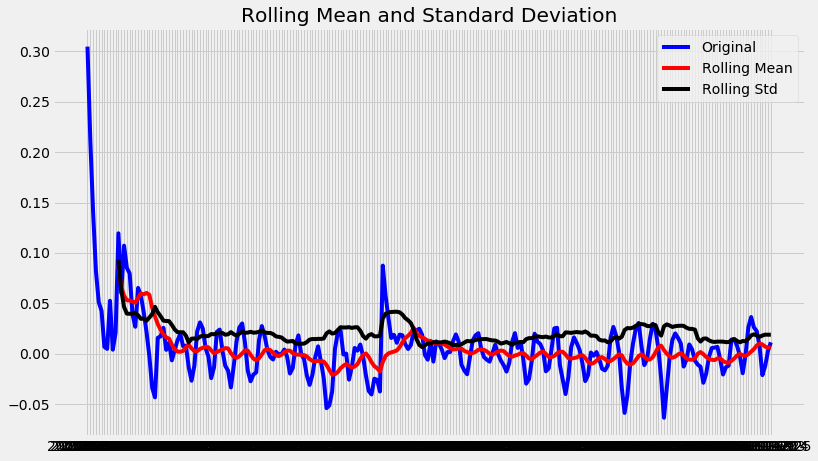

Results of dickey fuller test


KeyError: 'hospitalizedCurrently'

In [46]:
# perform decomposition which provides a structured way of thinking about a time series forecasting problem, 
# both generally in terms of modeling complexity and specifically in terms of how 
# to best capture each of these components in a given model.

from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(hosp_log, model='additive', freq = 12)
result.plot()
plt.show()
trend = result.trend
trend.dropna(inplace=True)
seasonality = result.seasonal
seasonality.dropna(inplace=True)
residual = result.resid
residual.dropna(inplace=True)
test_stationarity(residual)


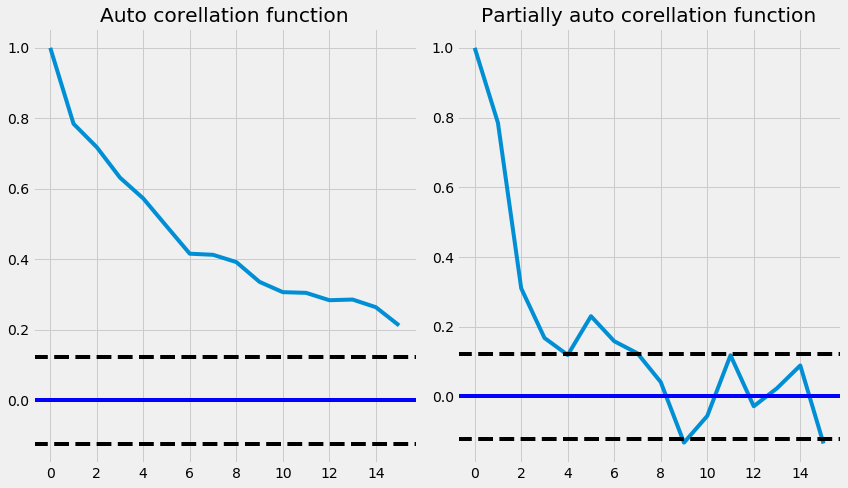

In [47]:
# Finding the best parameters for our model
from statsmodels.tsa.stattools import acf,pacf

# we use d value here(data_log_shift)
acf = acf(hosp_log_diff, nlags=15)
pacf= pacf(hosp_log_diff, nlags=15,method='ols')#plot PACF
plt.subplot(121)
plt.plot(acf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(hosp_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(hosp_log_diff)),linestyle='--',color='black')
plt.title('Auto corellation function')
plt.tight_layout()#plot ACF
plt.subplot(122)
plt.plot(pacf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(hosp_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(hosp_log_diff)),linestyle='--',color='black')
plt.title('Partially auto corellation function')
plt.tight_layout()

C:\Users\ideuk\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ideuk\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ideuk\anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


RSS : 0.268917


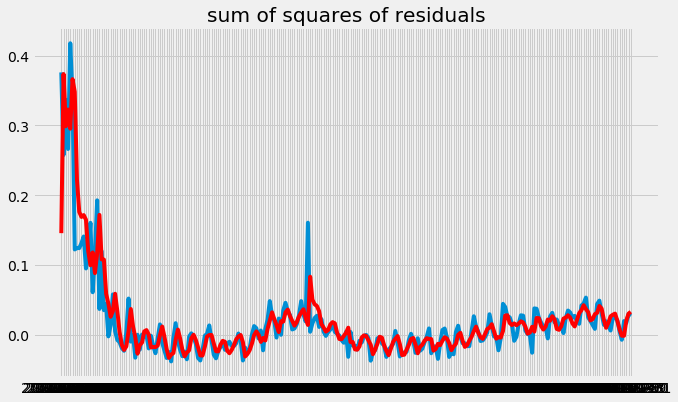

In [31]:
#Fitting model

from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(hosp_log, order=(3,1,3))
result_AR = model.fit(disp = 0)
plt.plot(hosp_log_diff)
plt.plot(result_AR.fittedvalues, color='red')
plt.title("sum of squares of residuals")
print('RSS : %f' %sum((result_AR.fittedvalues-hosp_log_diff["hospitalizedCurrently"])**2))


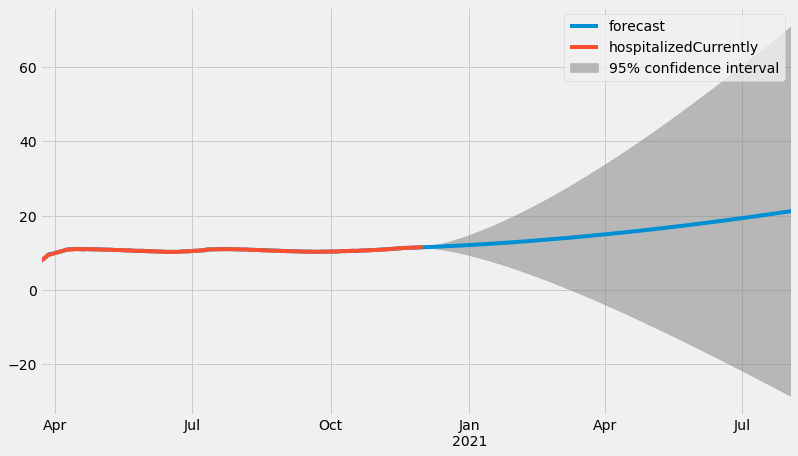

In [48]:
#  predictions
result_AR.plot_predict(1,500)
x=result_AR.forecast(steps=200)